# Tugas Besar IF3270 Pembelajaran Mesin
## Bagian A: Implementasi Forward Propagation untuk Feed Forward Neural Network

Anggota kelompok:

1. Christine Hutabarat (13520005)
2. Hana Fathiyah (13520047)
3. Yohana Golkaria Nainggolan (13520053)
4. Alifia Rahmah (13520122)



## 1. Perancangan struktur file eksternal untuk penyimpanan model

### Deklarasi Kelas

In [192]:
import networkx as nx
import matplotlib.pyplot as plt

class Case:
    def __init__ (self, model, input, weights):
      self.model = Model(model["input_size"], model["layers"])
      self.input = input
      self.weights = weights

      def get_arr_neurons_weights(weights):
        arr_neurons = []
        for i in weights:
           arr_neurons.append(i[1:])
        return arr_neurons
      
      self.neuron_weights = get_arr_neurons_weights(self.weights)
      
      def get_arr_bias_weights(weights):
        arr_bias = []
        for i in weights:
           arr_bias.append(i[0])
        return arr_bias
      
      self.bias_weights = get_arr_bias_weights(self.weights)

class Model:
    def __init__(self, input_size, layers):
        self.input_size = input_size

        def create_array_layer(layers):
            arr_layers = []
            for i in range(len(layers)):
                arr_layers.append(Layers(layers[i]["number_of_neurons"], layers[i]["activation_function"]))
            return arr_layers

        self.layers = create_array_layer(layers)
        self.cnt_layers = len(self.layers)

    def draw_compact_structure(self):
        # input layer
        print(f'x({self.layers[0].number_of_neurons})\t= {self.layers[0].activation_function}')
        print(' ↓ ')

        # hidden layer
        for i in range(1, len(self.layers)-1):
            print(f'h{i}({self.layers[i].number_of_neurons})\t= {self.layers[i].activation_function}')
            print(' ↓ ')

        # output layer
        print(f'y({self.layers[i + 1].number_of_neurons})\t= {self.layers[i + 1].activation_function}')

    def draw_structure(self):
        G = nx.Graph()

        # input layer
        for i in range(self.input_size + 1): # neuron+bias
            G.add_node(f'x{i}', pos=(1, i + 1)) # x1, x2, ...

        # hidden layer
        for i in range(len(self.layers) - 1): # layer+bias
            for j in range(self.layers[i].number_of_neurons + 1): # neuron+bias
                G.add_node(f'h{i+1}{j}', pos=(i + 2, j + 1)) # hi0, hi1, .., hij

                if (j > 0):
                    if (i == 0):
                        for k in range(self.input_size + 1):
                            G.add_edge(f'x{k}', f'h{i+1}{j}')
                    else:
                         for k in range(self.layers[i].number_of_neurons + 1):
                            G.add_edge(f'h{i}{k}', f'h{i+1}{j}')
                
        # output layer
        for i in range(self.layers[-1].number_of_neurons): # last hidden layer
            G.add_node(f'o{i+1}', pos=(len(self.layers) + 1, i+2))
            for j in range(self.layers[-1].number_of_neurons + 1):
                G.add_edge(f'h{len(self.layers)-1}{j}', f'o{i+1}')
                
        pos = nx.get_node_attributes(G, 'pos')
        fig, ax = plt.subplots()
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1000)
        nx.draw_networkx_edges(G, pos, ax=ax)
        labels = {n: n for n in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_color='white', ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.show()

class Layers:
    def __init__ (self, number_of_neurons, activation_function):
        self.number_of_neurons = number_of_neurons
        self.activation_function = activation_function

    def __str__ (self):
        return f'number of neurons: {self.number_of_neurons}\nactivation_function: {self.activation_function}\n'

### Deklarasi Fungsi Aktivasi

In [193]:
# Helper function
from math import exp

# net -> persamaan linear (ax+b+...)

def linear(net):
    return net

def relu(net):
    return max(0, net)

def sigmoid(net):
    return float(1/(1 + exp(net * -1)))

def softmax(net_i, arr_net):
    net_sum = 0
    for i in arr_net:
        net_sum += exp(i)

    return float(exp(net_i)/net_sum)

## 2. Implementasi load dari file teks

In [194]:
import json

def load_file(filename):
    f = open(filename)

    data = json.load(f)

    # get model
    model = data["case"]["model"]

    # get input data
    arr_input = data["case"]["input"]

    # get weights data
    arr_weight = data["case"]["weights"]

    # create object case
    case = Case(model, arr_input, arr_weight)

    f.close()

    return case

## 3. Implementasi forward propagation

In [195]:
import numpy as np

def ffnn(case):
    # create array of output
    output = []

    # print count input
    print(f'{len(case.input)} Input')

    # loop for every input
    for i in range(len(case.input)):
        print("************************************")
        current_data = [case.input[i]]

        # print input idx
        print(f"input ke-{i+1}")

        # print input layer
        print(f"input layer has {len(case.input[i])} neurons")

        # print neurons
        print(f"input neurons:")
        print('x0 (bias) = 1')
        for j in range(len(case.input[i])):
            print(f'x{j+1} = {case.input[i][j]}')

        print("==================================")

        # print count of Hidden Layer
        print(f"{case.model.cnt_layers - 1} Hidden layer")

        # loop for every layer
        for j in range(case.model.cnt_layers):

            kombinasilinear = np.dot(current_data, case.neuron_weights[j]) + case.bias_weights[j]
            current_data = kombinasilinear

            current_data_cpy = current_data.copy()

            if( j == case.model.cnt_layers - 1):
                # print output layer
                print("==================================")
                print("Output layer")

            if (j < case.model.cnt_layers - 1):
                # print hidden layer
                print('----------------------------------')
                print(f"Hidden layer ke-{j+1}: {len(current_data[0])} neurons")
            else:
                # print output layer
                print(f"Output layer has {len(current_data[0])} neurons")

            # print bias
            if (j < case.model.cnt_layers - 1):
                print(f"n{j+1}0 (bias) = 1")

            # loop for every neuron
            for k in range(len(current_data[0])):

                if (case.model.layers[j].activation_function == "linear"):
                    current_data[0][k] = linear(current_data[0][k])
                if (case.model.layers[j].activation_function == "relu"):
                    current_data[0][k] = relu(current_data[0][k])
                if (case.model.layers[j].activation_function == "sigmoid"):
                    current_data[0][k] = sigmoid(current_data[0][k])
                if (case.model.layers[j].activation_function == "softmax"):
                    current_data[0][k] = softmax(
                        current_data_cpy[0][k], current_data_cpy[0])

                if (j < case.model.cnt_layers - 1):
                    # neuron in hidden layer
                    print(f"n{j+1}{k+1} = {current_data[0][k]}")
                else:
                    # neuron in output layer
                    print(f"o{j+1}{k+1} = {current_data[0][k]}")

        output.append(current_data)
        print("************************************")
    return output

### a. Menampilkan struktur jaringan

In [196]:
# TODO: add model.draw_compact_structure() implementation here after implement read file above

In [197]:
# TODO: add model.draw_structure() implementation here after implement read file above

### b. Memprediksi output untuk input 1 instance

In [198]:
case_one_instance_data = {
        "model": {
            "input_size": 3,
            "layers": [
                {
                    "number_of_neurons": 4,
                    "activation_function": "relu"
                },
                {
                    "number_of_neurons": 3,
                    "activation_function": "sigmoid"
                },
                {
                    "number_of_neurons": 2,
                    "activation_function": "softmax"
                },
                {
                    "number_of_neurons": 2,
                    "activation_function": "linear"
                }
            ]
        },
        "input": [
            [
                7.0,
                2.4,
                3.6
            ]
        ],
        "weights": [
            [
                [
                    0.6,
                    0.2,
                    1.8,
                    2.5
                ],
                [
                    2.5,
                    1.2,
                    -0.3,
                    1.4
                ],
                [
                    0.6,
                    -0.3,
                    0.7,
                    1.2
                ],
                [
                    2.2,
                    -1.3,
                    0.6,
                    1.4
                ]
            ],
            [
                [
                    1.4,
                    4.5,
                    2.4
                ],
                [
                    2.6,
                    1.2,
                    1.3
                ],
                [
                    1.1,
                    1.4,
                    -0.5
                ],
                [
                    0.1,
                    -0.4,
                    1.2
                ],
                [
                    2.4,
                    -1.6,
                    0.4
                ]
            ], 
            [
                [
                    0.7,
                    1.3
                ],
                [
                    0.5,
                    1.2
                ],
                                [
                    1.3,
                    -0.5
                ],
                [
                    2.2,
                    0.2
                ]
            ],
            [
                [
                    0.8,
                    1.3
                ],
                [
                    2.2,
                    -2.1
                ],
                [
                    -0.8,
                    1.7
                ]
            ]
        ]
    }

In [199]:
# get model
model_one_instance = case_one_instance_data["model"]

# get input data
arr_input_one_instance = case_one_instance_data["input"]

# get weights data
arr_weight_one_instance = case_one_instance_data["weights"]

# create object case
case_one_instance = Case(model_one_instance, arr_input_one_instance, arr_weight_one_instance)

In [200]:
# TODO: move to menampilkan struktur jaringan
case_one_instance.model.draw_compact_structure()

x(4)	= relu
 ↓ 
h1(3)	= sigmoid
 ↓ 
h2(2)	= softmax
 ↓ 
y(2)	= linear


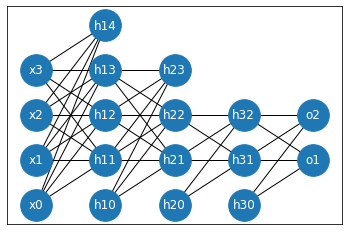

In [201]:
# TODO: move to
#  menampilkan struktur jaringan
case_one_instance.model.draw_structure()

In [202]:
output = ffnn(case_one_instance)
print(output)

1 Input
************************************
input ke-1
input layer has 3 neurons
input neurons:
x0 (bias) = 1
x1 = 7.0
x2 = 2.4
x3 = 3.6
3 Hidden layer
----------------------------------
Hidden layer ke-1: 4 neurons
n10 (bias) = 1
n11 = 27.460000000000004
n12 = 3.1999999999999993
n13 = 3.54
n14 = 20.22
----------------------------------
Hidden layer ke-2: 3 neurons
n20 (bias) = 1
n21 = 1.0
n22 = 0.9997153598140323
n23 = 1.0
----------------------------------
Hidden layer ke-3: 2 neurons
n30 (bias) = 1
n31 = 0.9241058943697005
n32 = 0.07589410563029957
Output layer
Output layer has 2 neurons
o41 = 2.772317683109102
o42 = -0.5116023986048619
************************************
[array([[ 2.77231768, -0.5116024 ]])]


### c. Memprediksi output untuk input sejumlah instance

## 4. Pengujian kebenaran fungsional

### a. Memprediksi kasus dengan test case linear.json


In [203]:
case_linear = load_file("linear.json")
output_linear = ffnn(case_linear)



1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 3.0
x2 = 1.0
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 2.0
o12 = 0.3000000000000001
o13 = -1.9000000000000004
************************************


### b. Memprediksi kasus dengan test case relu.json


In [204]:
case_relu = load_file("relu.json")
output_relu = ffnn(case_relu)

print(output_relu)

1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = -1.0
x2 = 0.5
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 0.04999999999999996
o12 = 1.1
o13 = 0.0
************************************
[array([[0.05, 1.1 , 0.  ]])]


### c. Memprediksi kasus dengan test case softmax.json

In [205]:
case_softmax = load_file("softmax.json")
output_softmax = ffnn(case_softmax)

print(output_softmax)

1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 1.0
x2 = 2.0
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 0.6652409557748219
o12 = 0.09003057317038045
o13 = 0.24472847105479764
************************************
[array([[0.66524096, 0.09003057, 0.24472847]])]


### d. Memprediksi kasus dengan test case sigmoid.json

In [206]:
case_sigmoid= load_file("sigmoid.json")
output_sigmoid = ffnn(case_sigmoid)

print(output_sigmoid)

1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 0.2
x2 = 0.4
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 0.617747874769249
o12 = 0.5890404340586651
o13 = 0.574442516811659
************************************
[array([[0.61774787, 0.58904043, 0.57444252]])]


### e. Memprediksi kasus dengan test case multilayer.json

In [207]:
case_multilayer = load_file("multilayer.json")
output_multilayer = ffnn(case_multilayer)

print(output_multilayer)

3 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 1.0
x2 = 0.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = 0.5
n12 = -1.5
Output layer
Output layer has 2 neurons
o21 = 2.0
o22 = 0.0
************************************
************************************
input ke-2
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 0.0
x2 = 1.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = -0.5
n12 = 0.5
Output layer
Output layer has 2 neurons
o21 = 0.0
o22 = 2.0
************************************
************************************
input ke-3
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 0.0
x2 = 0.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = 0.5
n12 = 0.5
Output layer
Output layer has 2 neurons
o21 = 0.0
o22 = 0.0
*******************************